In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import resample

# Univariate feature selection
## Feature filtering based on $\chi^2$-Test for classification

To create a hypothesis test, we propose the following:
1. Null Hypothesis: The feature is is not significant. In other words, the feature is useless and doesn't provide anything useful.
2. Alternative Hypothesis: The feature is significant and provides useful insight statistically.

To find out what hypothesis holds, we need to compute the `p-value`.
- The `p-value` is the *probability* of obtaining results that are *at least as extreme* (i.e outliers) as the results observed.
- These observations are under the assumption that the Null hypothesis is correct (the feature is useless).
- However, if the `p-value` is small, then it means that our *observed extreme results* are very unlikely under the Null hypothesis. 
- Therefore, given some significance threshold $\alpha$ (usually at 0.05), we **reject the Null hypothesis** i.f.f (if and only if) the `p-value` < $\alpha$.

In [3]:
# this is the same table of data from above 
data = pd.DataFrame([[1,0,1], [1,1,1], [1,1,1], [1,0,0], [1,1,1], [0,0,0], [0,0,0], [0,0,0], [1,1,0], [0,0,0]], 
                    columns=['HighSales','HasSequel','IsPopular'])

data

,HighSales,HasSequel,IsPopular
0,1,0,1
1,1,1,1
2,1,1,1
3,1,0,0
4,1,1,1
5,0,0,0
6,0,0,0
7,0,0,0
8,1,1,0
9,0,0,0


In [4]:
# set our alpha significance level
ALPHA = 0.05

# get our features and class label
features = data[['HighSales','HasSequel']]
class_label = data['IsPopular']

In [5]:
cont_table = pd.crosstab(class_label, features['HighSales'])
cont_table

HighSales,0,1
IsPopular,,
0,4,2
1,0,4


In [6]:
chi2_val, p, dof, expected_values = stats.chi2_contingency(cont_table.values, correction=False)
print(chi2_val)
print(p)
print(dof)

# this is the expected values for the Chi^2 test
print(expected_values)

4.444444444444445
0.03501498101966245
1
[[2.4 3.6]
 [1.6 2.4]]


From above, we can see that our `p-value` is $\approx0.035$ which is less than $\alpha=0.05$. Therefore, we would **reject the Null Hypothesis**.

To do both `HighSales` and `HasSequel` together, we can use a `for` loop as shown below:

In [7]:
filtered_features = []

for feature in ('HighSales','HasSequel'):
    cont_table = pd.crosstab(class_label, features[feature])
    chi2_val, p, dof, expected = stats.chi2_contingency(cont_table.values, correction=False)
    
    print(f'Chi2 value for feature "{feature}": {chi2_val:.4f}')
    
    if(p < ALPHA): 
        filtered_features.append(feature)
        print(f'Reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
    else:
        print(f'Fail to reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
        
print('Feature set after filtering with Chi-square test:', filtered_features)

Chi2 value for feature "HighSales": 4.4444
Reject the Null Hypothesis for feature "HighSales", p-value 0.0350

Chi2 value for feature "HasSequel": 3.4028
Fail to reject the Null Hypothesis for feature "HasSequel", p-value 0.0651

Feature set after filtering with Chi-square test: ['HighSales']


## Feature filtering based on Mutual Information for classification

In a similar fashion, we can use Mutual Information (MI) as the metric to evaluate how well-correlated the feature is with the class if the feature is a discrete variable.

In [8]:
filtered_features = []

# Similar to ALPHA in Chi-square testing, we select a threshold level for accepting / rejecting features
THRESHOLD = 0.2

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    
    if(mi >= THRESHOLD): 
        filtered_features.append(feature)
        
print('\nFeature set after filtering with MI:', filtered_features)

MI value for feature "HighSales": 0.2911
MI value for feature "HasSequel": 0.1777

Feature set after filtering with MI: ['HighSales']


# Evaluation method

## <u> Concept: $k$-fold Cross Validation (CV)</u>
- The approach randomly divides the dataset into $k$ approximately equal "folds" or "partitions".
- Each of these "folds" is then used as an evaluation set in $k$ different iterations. 
- That is, each iteration of $k$-fold CV will have different "folds" taking turns at being the evaluation set.

For example, if we had $k=3$, then:
- The first iteration involves having "folds" 1 & 2 for train, with 3 for evaluation.
- In the next iteration, we might have "folds" 1 & 3 for train, with 2 for evaluation.
- (and so on...)

- The common train-test split is unreliable due to some factors such as a fixed random seed. You may end up with biased labels or data points in specific splits which can lead to poor model fitting or over fitting.
- $k$-fold CV overcomes this by using every partition for training and testing, then, taking the average performance for a more reliable accuracy.
- However, $k$-fold CV is much slower in run-time as you need to re-train and re-test the model several times.

### Data preparation

In [9]:
data = pd.read_csv('sentiment.csv')
data.head()

,review,sentiment
0,"""Avengers: Endgame"" is about memories, nostalg...",0
1,"""Avengers: Endgame"" is an excellent commercial...",1
2,"""Avengers: Endgame"" is nothing short of a spec...",1
3,"""Avengers: Endgame"" is probably one of Marvel'...",1
4,(RottenTomatoes)- They delete my reviews frequ...,-1


In [10]:
# create our X and y features
X = data['review']
y = data['sentiment']

# vectorize our X matrix (bag-of-words format)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

print(X.shape)
X

(658, 6456)


<658x6456 sparse matrix of type '<class 'numpy.int64'>'
	with 31366 stored elements in Compressed Sparse Row format>

In [11]:
X = scipy.sparse.csr_matrix.todense(X)
X

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 5-fold cross validation with 5-NN classifier 

In [12]:
# set k=5 value for k-fold CV
k = 5

kf_CV = KFold(n_splits=k, shuffle=True, random_state=42)
results = []

The result is a generator object of `k` tuples in the form of (list of train indices, list of test indices). 

So, the idea is that we will grab the indices generated by the `kfold` and then subset `X` and `y` to get `X_train`, `X_test`, `y_train`, `y_test`. 

Note that this has to be done manually, as opposed to the normal use of `train_test_split`.

In [13]:
for train_idx, test_idx in kf_CV.split(X):
    # train-test split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Preprocessing
    # 1. Standardise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Training
    knn = KNN(n_neighbors=5)
    knn.fit(X_train, y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(y_test, y_pred))

In [14]:
print(f"Average Accuracy: {np.mean(results)}")

Average Accuracy: 0.4954661114966458


- _Generally, larger values of $k$ is useful for getting more accurate results as we have more training data._
- _For example, if $k$ were 2 or 3, we would end up with a 50/50 or 66/34 split which might be ineffective._
- _However, if we choose $k$ to be too large, it will take far longer to process and retrain the model._
- _To further improve this, there are techniques such as stratified $k$-fold CV or repeated $k$-fold CV._

# Performance metrics for imbalanced classification

 Alternative metrics, namely recall, precision and F1 score.

-1    360
 1     40
Name: sentiment, dtype: int64


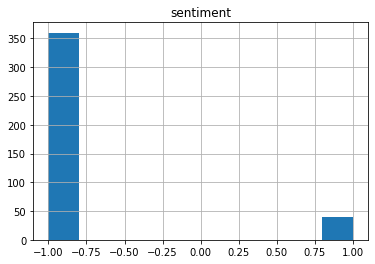

In [15]:
# Load the imbalanced dataset
imbalance = pd.read_csv('sentiment_imbalance.csv')

# Check the class label to see that it is imbalanced classification (N=400)
print(imbalance['sentiment'].value_counts())
imbalance.hist('sentiment')
plt.show()

In [16]:
# Get X, y
X_imb = imbalance['review']
y_imb = np.array(imbalance['sentiment'])

# CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_imb = vectorizer.fit_transform(X_imb) # Encoding text into BoW format and treat them as nominal features
print('Number of rows & columns:', X_imb.shape)
X_imb = scipy.sparse.csr_matrix.todense(X_imb)

Number of rows & columns: (400, 4034)


In [17]:
# Train the 5-NN model on a single holdout
X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X_imb, y_imb, train_size=0.8, random_state=42)

print('Distribution of test classes:')
pd.Series(y_imb_test).value_counts()

Distribution of test classes:


-1    70
 1    10
dtype: int64

In [18]:
knn = KNN(n_neighbors=5)
knn.fit(X_imb_train, y_imb_train)
y_imb_pred=knn.predict(X_imb_test)

print('Accuracy:', accuracy_score(y_imb_test, y_imb_pred))

Accuracy: 0.875


Remember that we have 70 test instances with `-1` class, and only 10 with `1` class (minority class). Just looking at the accuracy score of `0.875`, it looks like the model correctly predicted 70 out of 80 testing instances, which is great. But let's take a look at the confusion matrix to drill down its performance for each class:

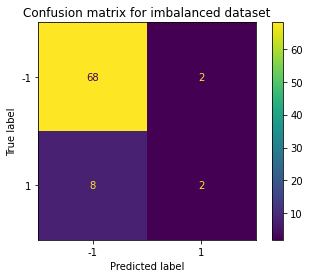

In [19]:
# Confusion matrix
cm = confusion_matrix(y_imb_test, y_imb_pred, labels=knn.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_).plot()
plt.title('Confusion matrix for imbalanced dataset')
plt.show()

As you can see, even though the model correctly predicted 70 instances, it only correctly predicted 2/10 minority class instances. In fact, the model only predicted 4 instances to be class `1`, which means that it is not a great model at all! Let's calculate some alternative metrics to evaluate this model using the `sklearn.metrics` module:

In [20]:
print('Recall:', recall_score(y_imb_test, y_imb_pred))
print('Precision:', precision_score(y_imb_test, y_imb_pred))
print('F1:', f1_score(y_imb_test, y_imb_pred))

Recall: 0.2
Precision: 0.5
F1: 0.28571428571428575


## Bootstrapping

For imbalanced datasets, however, we may also use **bootstrapping** instead of k-fold CV to get a range of performance scores. In this model evaluation method, you draw multiple training sets by random sampling from the training data wit replacement; these samples are called bootstrap samples. 
You train the model multiple times with the bootstrap samples.
You obtain the performance scores from the corresponding test sets.
The test set, for a bootstrap sample, contain observations not in (unseen) the bootstrap sample.

This set of scores give you a range of performance scores, from which you can calculate mean, sd and confidence interval of the performance.
They provide a distribution for the perfomance of the classification model.


Unlike k-fold, bootstrapping doesn't have an off-the-shelf function in `scikit-learn`, so we have to implement them with the `resample()` utility function. In the following section, we will show how you can use this function to generate repeated samples.

In [21]:
n = X_imb.shape[0]
# data index
dataidx = range(n)

# number of bootstrap samples
k = 10

# a list to store the bootstrap sample indices
bs = []

# Perform bootstrapping k times
for j in range(k):
    
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=j)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    bs.append((boot_index, oob_index))
    
# Note that the size of oob_index list is different for each bootstrapping,
# but the size of boot_index list is always the same (n)
print(bs[0])

([172, 47, 117, 192, 323, 251, 195, 359, 9, 211, 277, 242, 292, 87, 70, 88, 396, 314, 193, 39, 87, 174, 88, 337, 165, 25, 333, 72, 265, 115, 243, 197, 335, 338, 99, 177, 243, 285, 147, 147, 398, 288, 265, 185, 127, 32, 31, 202, 244, 151, 163, 370, 183, 28, 290, 128, 128, 53, 389, 38, 244, 273, 335, 388, 105, 42, 31, 376, 257, 321, 57, 291, 358, 119, 267, 82, 91, 384, 398, 99, 53, 396, 121, 84, 203, 324, 262, 47, 127, 131, 356, 180, 334, 143, 148, 227, 279, 207, 397, 373, 341, 48, 305, 69, 169, 163, 95, 197, 94, 256, 369, 178, 292, 304, 349, 387, 98, 42, 368, 201, 383, 0, 394, 370, 43, 383, 23, 187, 130, 377, 98, 62, 222, 123, 82, 227, 148, 209, 50, 270, 41, 58, 193, 36, 266, 86, 43, 360, 11, 258, 307, 80, 32, 182, 128, 294, 275, 174, 42, 371, 184, 77, 286, 280, 125, 258, 3, 94, 226, 363, 269, 368, 296, 328, 19, 95, 328, 248, 180, 323, 317, 270, 352, 260, 237, 139, 86, 377, 109, 331, 184, 16, 152, 149, 110, 25, 377, 374, 117, 83, 161, 360, 228, 251, 121, 326, 287, 13, 327, 184, 152, 79,

In practice, you don't need to generate the indices separately, but you can incorporate the resampling inside the for loop

In [22]:
# Storing the metrics for each dataset
accuracies = []
precisions = []
recalls = []
f1s = []

# Loop through each dataset, split data based on bootstrapping indices + fit model + evaluate
for k in range(10):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=k)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_imb_train = X_imb[boot_index,:]
    X_imb_test = X_imb[oob_index,:]
    y_imb_train = y_imb[boot_index]
    y_imb_test = y_imb[oob_index]
    
    # Train
    knn = KNN(n_neighbors=5)
    knn.fit(X_imb_train, y_imb_train)
    
    # Predict
    y_imb_pred=knn.predict(X_imb_test)
    
    # Evaluate
    accuracies.append(accuracy_score(y_imb_test, y_imb_pred))
    recalls.append(recall_score(y_imb_test, y_imb_pred))
    precisions.append(precision_score(y_imb_test, y_imb_pred))
    f1s.append(f1_score(y_imb_test, y_imb_pred))

In [23]:
print("Accuracy from each bootstrap sample:", accuracies)
#Display average of accuracy scores
avg_acc_score = np.mean(accuracies)
print("Mean accuracy from all bootstrap samples:", avg_acc_score)

Accuracy from each bootstrap sample: [0.8843537414965986, 0.8723404255319149, 0.8785714285714286, 0.8581081081081081, 0.8657718120805369, 0.8308823529411765, 0.7569444444444444, 0.9057971014492754, 0.7702702702702703, 0.7516339869281046]
Mean accuracy from all bootstrap samples: 0.8374673671821858


In [24]:
print("Precision from each bootstrap sample:", precisions)
#Display average of precision scores
avg_precision_score = np.mean(precisions)
print("Mean precision from all bootstrap samples:", avg_precision_score)

Precision from each bootstrap sample: [0.4, 0.3333333333333333, 0.5, 0.14285714285714285, 0.2222222222222222, 0.1, 0.2, 0.2, 0.1935483870967742, 0.08333333333333333]
Mean precision from all bootstrap samples: 0.2375294418842806


In [25]:
print("Recall from each bootstrap sample:", recalls)
#Display average of recall scores
avg_recall_score = np.mean(recalls)
print("Mean recall from all bootstrap samples:", avg_recall_score)

Recall from each bootstrap sample: [0.125, 0.058823529411764705, 0.4117647058823529, 0.18181818181818182, 0.4, 0.2857142857142857, 0.5, 0.1, 0.4, 0.1111111111111111]
Mean recall from all bootstrap samples: 0.25742318139376963
